In [1]:
import gnn
import torch
import helper_funcs
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GIN
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
torch.manual_seed(12345)
EPOCHS = 300
# import 3 datasets
imdb_dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora')
enzyme_dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

# Node classifcation: CORA

In [3]:
# init model
cora_mdl = GIN(in_channels = cora_dataset.num_features,
               hidden_channels = 5,
               out_channels = cora_dataset.num_classes,
               num_layers = 5)
optimizer = torch.optim.Adam(cora_mdl.parameters(), lr=0.01)

# train model
cora_mdl.train()
for epoch in range(EPOCHS * 5):
    optimizer.zero_grad()
    out = cora_mdl(cora_dataset.x, cora_dataset.edge_index)
    loss = F.cross_entropy(out, cora_dataset.y)
    #loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# evaluation
cora_mdl.eval()
pred = cora_mdl(cora_dataset.x, cora_dataset.edge_index).argmax(dim=1)
# Classification accuracy
correct = (pred[cora_dataset.test_mask] == cora_dataset.y[cora_dataset.test_mask]).sum()
acc = int(correct) / int(cora_dataset.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7320


Graph, using predicted class node color. 

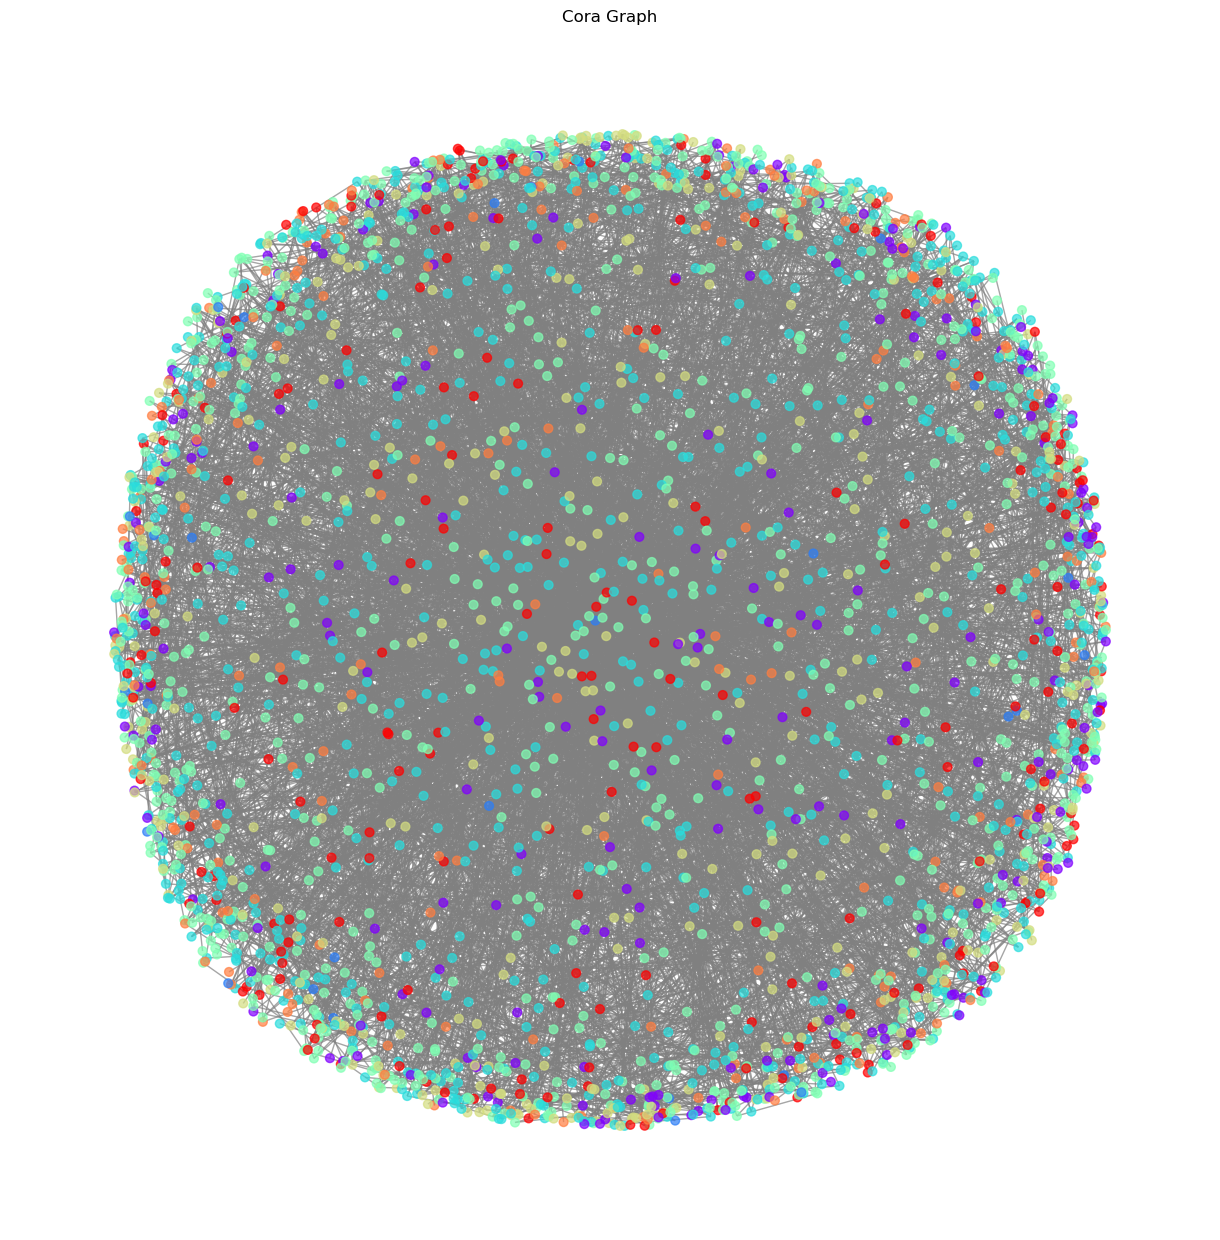

In [4]:
# graphing #
node_color = pred.cpu().numpy()
data = cora_dataset[0]
def visualize_graph(data, title="Graph"):
    # turn torch_geometric to networkx graph
    G = to_networkx(data, to_undirected=True)
    # get degrees / max degrees of each node
    degrees = dict(G.degree())
    max_degree = max(degrees.values())
    pos = nx.spring_layout(G, seed=42, k = 0.45)  
    # plot graph
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=False, node_color=node_color, cmap=plt.cm.rainbow, 
            node_size=40, edge_color="gray", alpha = 0.7)
    plt.title(title) # title
    plt.show()
    return G
G = visualize_graph(data, title="Cora Graph")

# Graph classifcation: IMDB

In [5]:
train_loader, test_loader = helper_funcs.preprocess_data(imdb_dataset, onehot=True, batch_size=64)

In [6]:
def IMDB_MDL(dataset, train_loader, test_loader, num_classes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = gnn.GINGraph(in_channels=dataset.num_node_features,
                 hidden_channels=64, 
                 out_channels=num_classes,
                 num_layers = 10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training the model
    for epoch in range(EPOCHS): 
        train_loss = gnn.GIN_train(model, train_loader, optimizer, device)
        test_acc = gnn.GIN_test(model, test_loader, device)
    return test_acc

print("Running GIN on IMDB_BINARY Dataset")
imdb_accuracy = IMDB_MDL(imdb_dataset, train_loader, test_loader, num_classes=2)
print(f"Final Accuracy on IMDB_BINARY: {imdb_accuracy:.4f}")

Running GIN on IMDB_BINARY Dataset
Final Accuracy on IMDB_BINARY: 0.7063


# Graph classification: ENZYME

In [7]:
# set up dataset
train_loader, test_loader = helper_funcs.preprocess_data(enzyme_dataset, onehot=False, batch_size=64)

In [8]:
# code adjusted from pytorch geometric
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = gnn.GIN2(enzyme_dataset.num_features, 32, enzyme_dataset.num_classes, num_layers=5)
model = model.to(device)
model = torch.jit.script(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00002, weight_decay=1e-5)

for epoch in range(EPOCHS):
    loss = gnn.GIN_train(model, train_loader, optimizer, device)
    test_acc =gnn.GIN_test(model, train_loader, device)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.5354
